# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.2.25 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import numpy as np
import os
from scipy.misc import imread, imresize
from imageio import imread
from skimage.transform import resize
import datetime
import os

import matplotlib.pyplot as plt
% matplotlib inline

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
def plot_score(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip "/content/drive/MyDrive/Project_data.zip" -d "/content/drive/MyDrive"

Streaming output truncated to the last 5000 lines.
 extracting: /content/drive/MyDrive/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: /content/drive/MyDrive/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: /content/drive/MyDrive/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: /content/drive/MyDrive/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: /content/drive/MyDrive/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: /content/drive/MyDrive/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: /content/drive/MyDrive/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: /content/drive/MyDrive/Project_data/trai

In [8]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
batch_size = 100 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(1,30,2)] #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = 80
    z = 80
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[0] == 360 and image.shape[1] == 360:
                        image = imresize(image[:,20:340,:], (80,80)).astype(np.float32)
                    elif image.shape[1] == 160:
                        image = imresize(image[:,20:140,:],(80,80)).astype(np.float32)
                    
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5))/ (np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5))/ (np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5))/ (np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5)) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    if image.shape[0] == 360 and image.shape[1] == 360:
                        image = imresize(image[:,20:340,:], (80,80)).astype(np.float32)
                    elif image.shape[1] == 160:
                        image = imresize(image[:,20:140,:],(80,80)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5))/ (np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5))/ (np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5))/ (np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5)) #normalise and feed in the image
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation , Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers 
import keras

#write your model here

model = Sequential()
model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(15,80,80,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1),padding='same'))

model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2),padding='same'))

model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2),padding='same'))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2),padding='same'))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2),padding='same'))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2),padding='same'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 80, 80, 32)    2624      
                                                                 
 batch_normalization (BatchN  (None, 15, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 15, 80, 80, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 40, 80, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 40, 80, 64)     55360     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 40, 80, 64)    2

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'


checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]



The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

# Model 1 num_epochs = 20 batch_size = 100 


In [ ]:
#num_epochs = 20
#batch_size = 100

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/20
5/7 [====================>.........] - ETA: 10:16 - loss: 6.2307 - categorical_accuracy: 0.3080

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


7/7 [==============================] - ETA: 0s - loss: 5.8259 - categorical_accuracy: 0.2805  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 100

Epoch 00001: saving model to model_init_2022-01-2519_43_58.624841/model-00001-5.82586-0.28054-2.12264-0.28000.h5
7/7 [==============================] - 2115s 334s/step - loss: 5.8259 - categorical_accuracy: 0.2805 - val_loss: 2.1226 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 2.8093 - categorical_accuracy: 0.2866  
Epoch 00002: saving model to model_init_2022-01-2519_43_58.624841/model-00002-2.80928-0.28658-3.32570-0.26000.h5
7/7 [==============================] - 773s 110s/step - loss: 2.8093 - categorical_accuracy: 0.2866 - val_loss: 3.3257 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 2.2367 - categorical_accuracy: 0.3243  
Epoch 00003: saving model to model_init_2022-01-2519_43_58

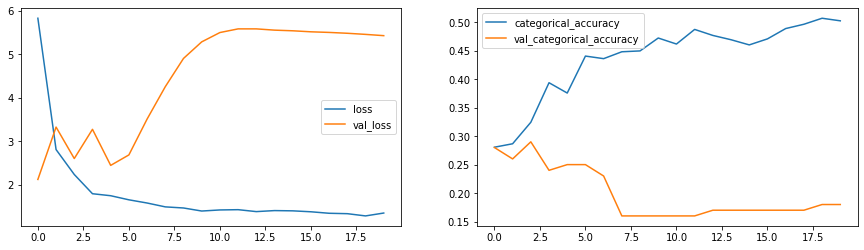

In [ ]:
plot_score(history)

# Model 2 num_epochs = 20 batch_size = 50

In [ ]:
num_epochs = 20 
batch_size = 50

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plot_score(history)

# Model 3 num_epochs = 30 batch_size = 32

In [16]:
num_epochs = 30 
batch_size = 32

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/30
5/7 [====================>.........] - ETA: 25s - loss: 6.1699 - categorical_accuracy: 0.2780

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


7/7 [==============================] - ETA: 0s - loss: 5.7319 - categorical_accuracy: 0.2685 Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 100

Epoch 00001: saving model to model_init_2022-01-2607_51_09.218975/model-00001-5.73187-0.26848-2.89181-0.23000.h5
7/7 [==============================] - 144s 21s/step - loss: 5.7319 - categorical_accuracy: 0.2685 - val_loss: 2.8918 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 2.6737 - categorical_accuracy: 0.3288 
Epoch 00002: saving model to model_init_2022-01-2607_51_09.218975/model-00002-2.67372-0.32881-2.30857-0.30000.h5
7/7 [==============================] - 141s 23s/step - loss: 2.6737 - categorical_accuracy: 0.3288 - val_loss: 2.3086 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 2.1060 - categorical_accuracy: 0.3695 
Epoch 00003: saving model to model_init_2022-01-2607_51_09.21897

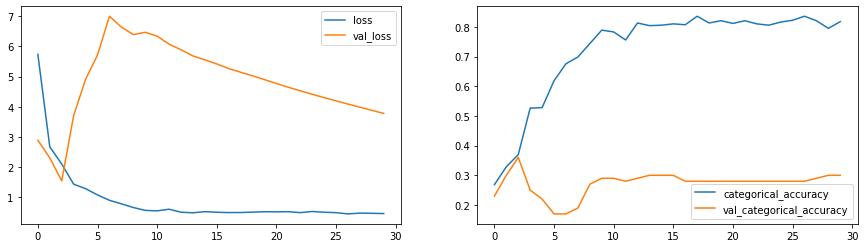

In [17]:
plot_score(history)

# Final model num_epochs = 30 batch_size = 32 learning rate = 0.0001

In [18]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'


checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1 

num_epochs = 30
#batch_size = 30

history =  model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 80, 80, 32)    2624      
                                                                 
 batch_normalization (BatchN  (None, 15, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 15, 80, 80, 32)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 40, 80, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 40, 80, 64)     55360     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 40, 80, 64)    2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/30
19/21 [==========================>...] - ETA: 8s - loss: 0.6139 - categorical_accuracy: 0.7714 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


21/21 [==============================] - ETA: 0s - loss: 0.6012 - categorical_accuracy: 0.7722Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2022-01-2607_51_09.218975/model-00001-0.60120-0.77225-3.37746-0.41000.h5
21/21 [==============================] - 109s 5s/step - loss: 0.6012 - categorical_accuracy: 0.7722 - val_loss: 3.3775 - val_categorical_accuracy: 0.4100 - lr: 1.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.4017 - categorical_accuracy: 0.8492
Epoch 00002: saving model to model_init_2022-01-2607_51_09.218975/model-00002-0.40172-0.84917-3.50330-0.41000.h5
21/21 [==============================] - 105s 5s/step - loss: 0.4017 - categorical_accuracy: 0.8492 - val_loss: 3.5033 - val_categorical_accuracy: 0.4100 - lr: 1.0000e-04
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.4576 - categorical_accuracy: 0.8190
Epoch 00003: saving model to model_init_2022-01-2607

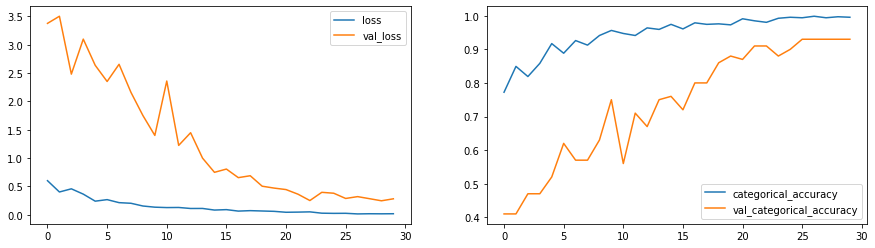

In [19]:
plot_score(history)